# Preprocessing notebook: Defamation in the U.S. 2016 Presidential Election

Working with text requires undertaking a thorough data cleaning process as the first and most crucial step. Twitter users have diverse writing styles. To ensure a fair representation of words or phrases expressing similar things, we changed parts of the data such as correcting misspelled words or expanding contractions. Given its strict 140 character limit per tweet, Twitter motivates people to use short-form word representation, acronyms, emojis or slang to deliver their message while staying within the character limit. Because of this, our data cleaning was essential to having high-quality input data for our model.

The preprocessing, outlined below, allowed us to explore and analyze the data in an easier way where we can see the top words and hashtags used in our text. This information confirms the main target of the users was the US election with a particular focus on Donald Trump, Barack Obama, and Hilary Clinton.

Data pre-processing steps:
    
- Using the 'Tweet Preprocessor' library, we selected the tweet texts from our dataset and stored all hashtags, emojis, and mentions for later use.
- After storing separately the elements we need,  we removed all hashtags, mentions, emojis, numbers, and URLs from the text.
- Item To avoid case-sensitive processes, we changed the entire tweets to lowercase representation.
- Item Removal of all symbols and punctuation (e.g. ! ? , . / ~)
- Item To ensure that words such as "you're" and "you are" are treated equally, we expanded all contractions in the text.
- Item In text analysis, individual words that form a text need to be represented numerically. We ensured that the tweets were represented as a list of individual words as opposed to a single sentence.
- Item Stop words are words that are very common across all text (e.g. and, the, to, with, from). These words do not add value to text analysis and were removed from all tweets.
- Item When words only appear in a few tweets from a 500,000+ corpus, they only contribute to making a word vector matrix more sparse, thus removing rare words helps condense the data.
- Item The final step before the finish line was substituting words that have extra unnecessary letters (e.g. caaaat) to its correct spelling (e.g. cat).

# Import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from re import search
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import preprocessor as tp
import emoji
import contractions
from langdetect import detect
import collections
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import csv
import os
os.getcwd()

# Load data 

In [3]:
data = pd.read_csv('data/russian_linked_tweets_csv_hashed.csv', low_memory=False)
data["tweet_time"] = pd.to_datetime(data['tweet_time'])
print("date range: " +str(min(data["tweet_time"])) + " , " + str(max(data["tweet_time"])))

date range: 2010-08-03 12:39:00 , 2018-11-06 18:04:00


# Preprocess

In [4]:
# Option 1: Subset data by date range
start_date, end_date = "2014-07-01", "2017-10-01"
date_mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)

In [5]:
data_subset = data[date_mask]
data_subset = data_subset[['tweetid', 'userid', 'user_screen_name', 
                           'user_reported_location','user_profile_description', 
                           'tweet_text', 'hashtags', 'tweet_language', 'tweet_time',
                          'follower_count', 'following_count']]
# is_en = data_subset['tweet_language'] == 'en'
data_subset = data_subset[data_subset['tweet_language'] == 'en']

In [6]:
# # output dataframe to csv
# data_subset_en.to_csv('en_tweets.csv', quoting=csv.QUOTE_NONNUMERIC)

In [7]:
# # Option 2: Subset data by indices
# data_subset = data[['tweetid','user_screen_name', 'user_reported_location',
#                     'user_profile_description', 'tweet_text', 'hashtags', 'tweet_language', 'tweet_time']]
# # filter for english language tweets
# is_en = data_subset['tweet_language'] == 'en'
# data_subset = data_subset[is_en]
# print(len(data_subset))
# #data_subset["tweet_time"] = pd.to_datetime(data_subset['tweet_time'])
# # subset dataframe
# data_subset = data_subset.iloc[0:10000,:]
# data_subset.head()

In [8]:
# Remove original dataframe from memory in order to free up space
# del data

In [9]:
# observe random tweets
i = np.random.randint(low = 0, high = len(data_subset))
print(i)
print(data_subset.tweet_text[i])
print('==============================================')
# undertand how the tweet preprocessor library works
tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.MENTION, tp.OPT.NUMBER, tp.OPT.HASHTAG, tp.OPT.SMILEY)
tp.tokenize(data_subset.tweet_text[i])

539789
RT @MolonLabeIndust: BLM Race Pimps Nationwide Day Of Rage Protests Planned https://t.co/KVxQwZmOzi https://t.co/FFvnjpY323


'RT $MENTION$: BLM Race Pimps Nationwide Day Of Rage ProtestsPlanned $URL$ $URL$'

In [6]:
def extract_elements(tweets):
    """ Function that uses the tweet-preprocessor and emojis libraries 
        to identify and save:
            - #Hashtags
            - @Mentions
            - Emojis 
        
    Args:
        tweets: list containing all tweets
        
    Returns: 
        hashtags: list of hashtags
        mentions: list of mentions
        emojis: list of emojis

    """

    # set the global options for the library (which elements of the tweet pay attention to)
    tp.set_options(tp.OPT.URL, tp.OPT.EMOJI, tp.OPT.MENTION, tp.OPT.NUMBER, tp.OPT.HASHTAG)
    
    # create empty lists to store the resuts
    hashtags = []
    mentions = []
    emojis = []
    
    # iterate over all tweets in the list
    for tweet in tweets:
        
        # parse tweet to extract the relevant elements defined in the options
        parsed_tweet = tp.parse(tweet)
        
        # 1. save the hashtags
        h_tweet = []
        if parsed_tweet.hashtags != None:
            for hashtag in parsed_tweet.hashtags:
                h_tweet.append(hashtag.match)

        # save to the global list as a space separated string
        hashtags.append(' '.join(h_tweet))
        
        
        # 2. save the emojis (using the library)
        e_tweet = []
        if len(emoji.emoji_lis(tweet)) > 0:
            for e in emoji.emoji_lis(tweet):
                e_tweet.append(e['emoji'])

        # save to the global list as a space separated string
        emojis.append(' '.join(e_tweet))
        
        # 3. save the mentions
        m_tweet = []
        if parsed_tweet.mentions != None:
            for mention in parsed_tweet.mentions:
                m_tweet.append(mention.match)
        
        # save to the global list as a space separated string
        mentions.append(' '.join(m_tweet))
    
    
    return(hashtags, mentions, emojis)

In [7]:
# hashtags, mentions, emojis = extract_elements(data_subset.tweet_text)

In [8]:
# len(hashtags), len(mentions), len(emojis)

In [9]:
def tweet_preprocessor(tweets):
    """ Function that uses the tweet-preprocessor and emojis libraries 
        to remove: 
            - #Hashtags
            - @Mentions
            - Emojis
            - URLs
            - Standalone numbers
            
        and transform all letters into lower case
        
    Args:
        tweets: list containing all tweets
        
    Returns: 
        clean_tweets: lower-cased preprocessed list of tweets
        
    Sources:
        https://pypi.org/project/tweet-preprocessor/
        https://github.com/carpedm20/emoji/

    """
    
    # set the global options for the library (which elements of the tweet pay attention to)
    tp.set_options(tp.OPT.URL, tp.OPT.MENTION, tp.OPT.NUMBER, tp.OPT.HASHTAG)
    
    # create a list to store the results
    clean_tweets = []
    
    # iterate over all tweets in the list
    for tweet in tweets:
        
        # remove emojis
        for e in emoji.emoji_lis(tweet):
            tweet = tweet.replace(e['emoji'], '')
        
        # append the cleaned lowered-cassed tweet
        clean_tweets.append(tp.clean(tweet).lower())
    
    return(clean_tweets)

In [10]:
# clean_text = tweet_preprocessor(data_subset.tweet_text)

In [11]:
# i = np.random.randint(low = 0, high = len(data_subset))
# print(data_subset.tweet_text[i]) 
# print(' ================================== ')
# print(clean_text[i])

In [12]:
def remove_symbols(tweets, symbols):
    """ Function that  uses regular expressions to delete all symbols
        given by the user from the tweets
        
    Args:
        tweets: list containing all tweets
        symbols: list containing all the symbols to replace
        
    Returns: 
        clean_tweets: list of tweets without symbols 
        
    """
    
    # generate regular expression
    rx = '[' + re.escape(''.join(my_symbols)) + ']'
    
    # create empty list to store results
    clean_tweets = []
    for tweet in tweets:
        clean_tweets.append(re.sub(rx, '', tweet))
        
    return(clean_tweets)

In [13]:
my_symbols = list(string.punctuation)
my_symbols.remove("'")
my_symbols.append('…')
my_symbols.append('»')
my_symbols.append('«')
print(my_symbols)

['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '…', '»', '«']


In [14]:
# clean_text = remove_symbols(clean_text, my_symbols)

In [15]:
# i = np.random.randint(low = 0, high = len(data_subset))
# print(data_subset.tweet_text[i]) 
# print(' ============================================ ')
# clean_text[i]

In [16]:
print(contractions.fix("you're happy now"))
print(contractions.fix("yall're happy now", slang=False))
print(contractions.fix("yall're happy now"))
print(contractions.fix("we'll go to the bar"))
print(contractions.fix("i'm hungry right now"))
print(contractions.fix("we are working on text mining"))

you are happy now
yall're happy now
you all are happy now
we will go to the bar
I am hungry right now
we are working on text mining


In [17]:
def expand_contractions(tweets):
    """ Function to transform some of the most common English and 
        French contractions into their expanded form
        
    Args:
        tweets: list containing all tweets
        
    Returns: 
        clean_tweets: list of tweets with the contractions expanded
    """
    
    # create a list for storing the results
    clean_tweets = []
    for tweet in tweets:
        clean_tweets.append(contractions.fix(tweet).lower())
        
    
    return(clean_tweets)

In [18]:
# clean_text2 = expand_contractions(clean_text)

In [19]:
# i = np.random.randint(0,10000)
# print(clean_text[i])
# print(clean_text2[i])

In [20]:
# tweets_words = [tweet.split() for tweet in clean_text2]

In [21]:
# len(tweets_words)

In [22]:
def remove_stopwords(tweets_words, stop_words):
    """ Function to remove a list of words from all the corpus
        
    Args:
        tweets_words: list containing all tweets represented as lists of words
        stop_words: list of words to be removed
        
    Returns: 
        clean_words: list of tweets without stop_words
        
    """
    
    # create a list of empty lists to store the results
    clean_words = [[] for tweet in tweets_words] 
    for i,tweet in enumerate(tweets_words):
        for word in tweet: 
            if word not in stop_words: 
                clean_words[i].append(word)

    return(clean_words)

In [23]:
# download stop words
nltk.download('stopwords')

# load all stop words 
stop_words = stopwords.words('english') # + other languages? chinese/russian?

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristin.lomicka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# len(stop_words)

In [25]:
# clean_words = remove_stopwords(tweets_words, stop_words)

In [26]:
# i = np.random.randint(low = 0, high = len(data_subset))
# print(data_subset.tweet_text[i]) 
# print(' ============================================ ')
# print(clean_words[i])

In [27]:
def replace_multiple(tweets_words):
    """ Function to replace 3 or more consecutive vocals (caaaaaat)
        with only one appearance (cat)
        
    Args:
        tweets_words: list of tweets represented as lists of words
        
    Returns: 
        clean_tweets
    """

    def replace(string, char): 
        pattern = char + '{3,}'
        string = re.sub(pattern, char, string) 
        return string 
    
    def replace_vocals(string):
        vocals = ["a","e", "i", "o", "u"]
        clean = string
        for char in vocals:
            clean = replace(clean,char)
        return clean

    # create an empty list to store the results
    clean_tweets = []
    for tweet in tweets_words:
        clean_words = [replace_vocals(word) for word in tweet] 
        clean_tweets.append(clean_words)
    
    return(clean_tweets)

In [33]:
def remove_rare_words(tweets):
    # join all tweets together so it's a long list of words
    all_words = [word for sent in tweets for word in sent]

    # calculate the frequency of each of the words
    freq_dist = nltk.FreqDist(all_words)

    # create list of words that appear <= 3 times in the whole corpus
    rare_words = {k:v for k,v in freq_dist.items() if v <= 3}
    
    words_to_add = {'rt': 1, 
                'http': 1, 
                'https': 1,
                    'amp': 1,
                   'uy41ohlqpejzkqhs': 1,
                   'a3g4wu5athso': 1,
                   "\'s" : 1,
                   "mt" : 1,
                   "htt" : 1}

    rare_words.update(words_to_add)
    
    clean_tweets_final = [[word for word in sent if word not in rare_words.keys()] for sent in tweets]
    
    return clean_tweets_final

In [33]:
# clean_words = replace_multiple(clean_words)

In [34]:
# i = np.random.randint(low = 0, high = len(data_subset))
# print(i)
# print(data_subset.tweet_text[i]) 
# print(' =================================== ')
# print(clean_words[i])

### Merge all the prior functions into one

In [34]:
def preprocessor(tweets, symbols, stop_words):
    """ Function that applies sequentially the following cleaning 
        procedures to the list of tweets provided as an input:

        1. identifies and stores
            a. #Hashtagas
            b. @Mentions
            c. Emojis
        2. removes from the text:
            a. #Hashtags
            b. @Mentions
            c. Emojis
            d. URL's
            e. Standalone numbers  
        3. converts all letters into lowercase
        4. removes user-specified symbols
        5. expands some basic contractions (French only)
        6. represents every tweet as a list of words
        7. removes user-specified stopwords
        8. replaces muuuuultiple appearances of a letter in a word
    
    Args:
        tweets: list containing all tweets
        symbols: list containing all symbols to be removed
        stopwords: list containing all stopwords to be removed
        
    Returns: 
        tweets_words: list of tweets represented as lists of words
        hashtags: list of hashtags
        mentions: list of mentions
        emojis: list of emojis   
    """

    
    # 1.
    hashtags, mentions, emojis = extract_elements(tweets)
    
    # 2 and 3
    clean_tweets = tweet_preprocessor(tweets)

    # 4. 
    clean_tweets = remove_symbols(clean_tweets, symbols)
     
    # 5. 
    clean_tweets = expand_contractions(clean_tweets)
    
    # 6.
    tweets_words = [tweet.split() for tweet in clean_tweets]
    
    # 7. 
    tweets_words = remove_stopwords(tweets_words, stop_words)
    
    # 8.
    tweets_words = replace_multiple(tweets_words)
    
    lmtzr = WordNetLemmatizer()
    
    tweets_words = [[lmtzr.lemmatize(word) for word in sent] for sent in tweets_words]
    
    tweets_words = remove_rare_words(tweets_words)

    return(tweets_words, hashtags, mentions, emojis)

In [35]:
# load all stop words 
stop_words = stopwords.words('english') # + other languages? chinese?

# load and add new punctutation 
my_symbols = list(string.punctuation)
my_symbols.remove("'")
my_symbols.append('…')
my_symbols.append('»')
my_symbols.append('«')
my_symbols.append('„')
my_symbols.append('“')
my_symbols.append("–")
print(my_symbols)

['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '…', '»', '«', '„', '“', '–']


In [36]:
# put everything together
clean_tweets, hashtags, mentions, emojis = preprocessor(data_subset.tweet_text, my_symbols, stop_words)

In [37]:
clean_df = pd.DataFrame({'clean_tweet': clean_tweets, 'hashtags': hashtags,
                         'mentions': mentions, 'emojis': emojis})

In [38]:
clean_df

,clean_tweet,hashtags,mentions,emojis
0,"[new, convoy, arrived]",#SyrianArmy #Hama #InsideSyriaMC,,
1,"[civilian, killed, mosul]",#Iraq #airstrike,@CJTFOIR,
2,"[truly, know, know, true, payback, hell, perso...",,,
3,"[remember, last, summer, dear, ️]",,,☀ 🌊 🐬 🐚 🏄 🏊 🚵 🍒 🍇 🍉 🍓 🍑
4,"[u, gay, arriage, refused, clerk, kkentucky]",,,
5,"[former, president, jimmy, carter, begin, radi...",,,
6,"[new, trove, purported, ashley, madison, data,...",,,
7,"[today's, lesson, islam, ️, ️]",#EducateYourselfOnIslam #StopIslamizationOfAme...,,☪ 👎 🏿 🕋 🕋 💀 ☪ 🕋 👹 💣 ❌
8,"[new, york, prison, escapee, david, sweat, ple...",,,
9,"[subway, jared, fogle, face, year, prison, ter...",,,


In [34]:
clean_df.to_csv('clean_df.csv')

In [41]:
i = np.random.randint(low = 0, high = len(data_subset))
print('\n ** Original tweet at index:', i, '\n')
print(data_subset.tweet_text[i]) 
print('================================================ \n')
print(' ** Cleaned text as words: \n')
print(clean_tweets[i])
print('================================================ \n')
print(' ** Hashtags: \n')
print(hashtags[i])
print('================================================ \n')
print(' ** Emojis: \n')
print(emojis[i])
print('================================================ \n')
print(' ** Mentions: \n')
print(mentions[i])


 ** Original tweet at index: 422748 

RT @andersonDrLJA: #SenChuckSchumer IS A  PERFECT EXAMPLE OF WHY #TermLImits Are A MUST!

#ConventionOfStates  #COS

#CongressDoYourJob htt…

 ** Cleaned text as words: 

['rt', 'perfect', 'example', 'must', 'htt']

 ** Hashtags: 

#SenChuckSchumer #TermLImits #ConventionOfStates #COS #CongressDoYourJob

 ** Emojis: 



 ** Mentions: 

@andersonDrLJA


### checkin out hashtags

In [39]:
# put hashtags in dictionary to see most frequent ones
hashtag_counter = collections.Counter(hashtags)

# sort by frequency
hashtag_counter = {k: v for k, v in sorted(hashtag_counter.items(), key=lambda item: item[1])}

# remove all keys with values < than 10
hashtag_counter = {k:v for k,v in hashtag_counter.items() if v >= 500}

# drop tweets with no hashtags
hashtag_counter = {k:v for k,v in hashtag_counter.items() if k != ''}

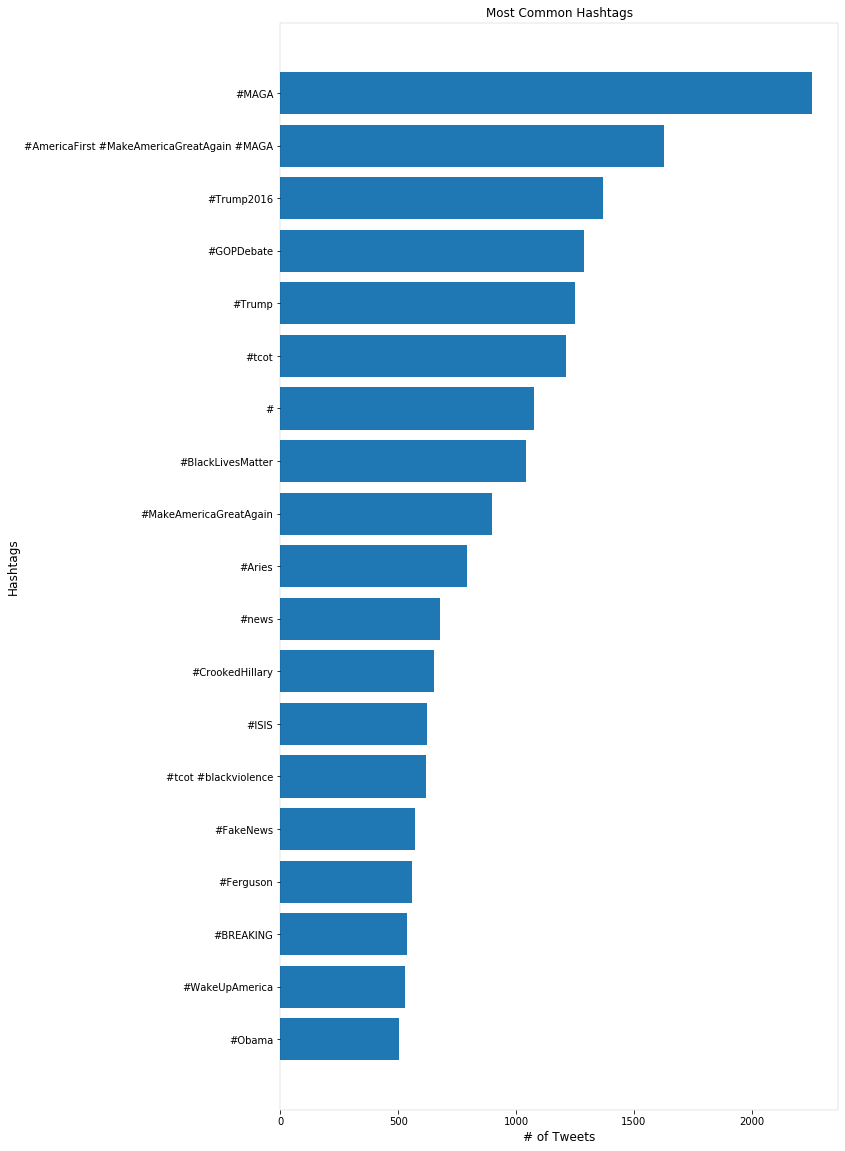

In [40]:
plt.figure(figsize=(10,20))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)

plt.barh(range(len(hashtag_counter)), hashtag_counter.values(), align='center')
plt.yticks(range(len(hashtag_counter)), list(hashtag_counter.keys()))
plt.title('Most Common Hashtags')
plt.ylabel('Hashtags')
plt.xlabel('# of Tweets')
plt.show()

### vectorizer

In [41]:
# join tweet words to input into the vectorizer
clean_tweets_joint = [" ".join(words) for words in clean_tweets]

In [42]:
# check tweets joined properly
i = np.random.randint(low = 0, high = len(clean_tweets))
print('split tweet:')
print(clean_tweets[i])
print('===============================================')
print('joint tweet:')
print(clean_tweets_joint[i])

split tweet:
['student', 'trip', 'see', 'santa', 'cancelled', 'jewish', 'mom', 'complains']
joint tweet:
student trip see santa cancelled jewish mom complains


In [ ]:
# # load the vec model
# vectorizer = TfidfVectorizer(min_df=2,
#                              max_df=.8,
#                              stop_words='english',
#                              use_idf=False,
#                              norm=False)

# v = vectorizer.fit_transform(clean_tweets_joint)
# v = np.asarray(v.todense())


# # get the labels (vocabulary), sorted by index
# labels, _ = zip(*sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1]))

# put the labels and average frequency into a dataframe 
# so it's easier to work with
labels_df = pd.DataFrame({'label': list(labels), 'mean': v.mean(axis=0)})

# select only frequencies higher than 0.01 for plotting (otherwise it's a 
# list of 3000+ words)
labels_df = labels_df[labels_df['mean'] >= 0.0]

# sort by frequency to plot
labels_df = labels_df.sort_values(by='mean', ascending=True)

len(labels_df)

In [47]:
len(labels_df)

57

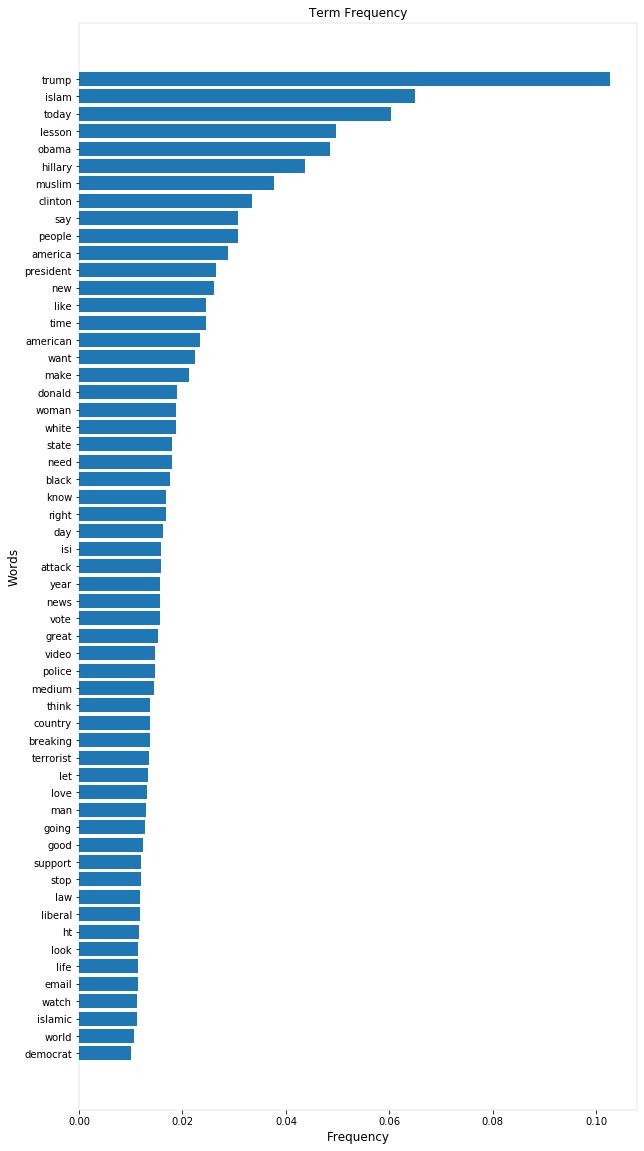

In [44]:
# plot the results 

plt.figure(figsize=(10,20))
plt.rc('axes', linewidth=0.1, titlesize=12, labelsize=12)

plt.barh(labels_df['label'], labels_df['mean'], align='center')
plt.title('Term Frequency')
plt.ylabel('Words')
plt.xlabel('Frequency')
plt.show()

In [45]:
# Pick clean_tweets
import pickle
# Pickle results
with open('clean_tweets', 'wb') as results:
    pickle.dump((clean_tweets), results)